In [50]:
import numpy as np
import pandas as pd
import sklearn as skl
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [51]:
#Wenjie's 
ds_test = pd.read_csv("we_data/test.csv")
ds_train = pd.read_csv("we_data/train.csv")
ds_val = pd.read_csv("we_data/validation.csv")

In [52]:
pearson = ds_train.corr(method='pearson')

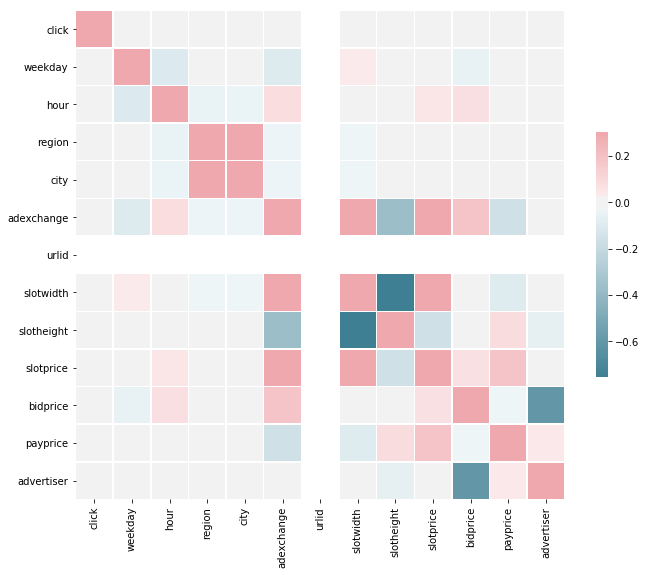

In [53]:
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(pearson, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})

# Gathering categorical and essential data from training set

In [54]:
df = ds_train

In [55]:
ua_split = df['useragent'].str.split('_', n=1, expand=True)
os_values = ua_split[0].unique()
browser_values = ua_split[1].unique()
ua_values = df['useragent'].unique()
hour_values = df['hour'].unique()
weekday_values = df['weekday'].unique()
region_values = df['region'].unique()
city_values = df['city'].unique()
slotv_values = df['slotvisibility'].unique()
slotf_values = df['slotformat'].unique()
sloth_values = df['slotheight'].unique()
slotw_values = df['slotwidth'].unique()

In [56]:
user_values = set()

for x in df.usertag.fillna(0):
    users = str(x).split(',')
    user_values.update(users)

In [57]:
# Average clickthrough rate
base_ctr = ds_train['click'].mean()
base_pay = ds_train['payprice'].mean()
base_click_pay = ds_train[ds_train['click'] == 1]['payprice'].mean()
base_bid = ds_train['bidprice'].mean()
print(f"Base CTR: {base_ctr}, Base Bid: {base_bid}, Base Pay: {base_pay}, Base Click Pay: {base_click_pay}")

Base CTR: 0.0007375623256619447, Base Bid: 272.9620461862927, Base Pay: 78.15141623895867, Base Click Pay: 105.46402677077523


In [81]:
downsample_rate = 0.025

# Helper functions

In [110]:
def preprocess(df_proc, downsample=1):
    """
    Columns:
    'click', 'weekday', 'hour', 'bidid', 'userid', 'useragent', 'IP',
    'region', 'city', 'adexchange', 'domain', 'url', 'urlid', 'slotid',
    'slotwidth', 'slotheight', 'slotvisibility', 'slotformat', 'slotprice',
    'creative', 'bidprice', 'payprice', 'keypage', 'advertiser', 'usertag'

    Columns with nulls:
    adexchange, domain, url, urlid, keypage, usertag    
    """
    # useragent replaced by os and browser
    df = df_proc.copy()

    # Sampling
    if 'click' in df:
        df_click_0 = df[df['click'] == 0]
        df_click_1 = df[df['click'] == 1]
        df_click_0_undersample = df_click_0.sample(frac=downsample)
        df = pd.concat([df_click_0_undersample, df_click_1], axis=0)
    else:
        df = df.sample(frac=downsample)
    
    not_used = ['bidid', 'userid', 'IP', 'slotid', 'useragent', 'creative']
    check_fields = ['bidprice', 'payprice']
    
            
    dum_req = ['os', 'browser', 'weekday', 'hour', 'slotvisibility', 'slotformat', 'advertiser', 'slotprice',
              'region', 'city', 'slotwidth', 'slotheight']
    
    cat_fields = [('os', os_values), ('browser', browser_values), ('slotformat', slotf_values), 
                 ('slotvisibility', slotv_values), ('region', region_values), ('city', city_values),
                 ('slotwidth', slotw_values), ('slotheight', sloth_values)]

    # Check if non essential fields are present 
    for field in check_fields:
        if field in df_proc.columns:
            not_used.append(field)

    # Obtain os and browser from useragent
    x = df['useragent'].str.split('_', n=1, expand=True)
    df['os'] = x[0] 
    df['browser'] = x[1]
    
    # Set categories for categorical fields
    for field, values in cat_fields:
        df[field] = pd.Categorical(df[field], categories=values)
       
    # Slot price
    bins = [-np.inf, 10, 50, 100, 150, np.inf]
    labels = ['sp_1','sp_2','sp_3','sp_4', 'sp_5']
    df['slotprice'] = pd.cut(df['slotprice'], bins=bins, labels=labels)

    # One hot encoding
    df = pd.get_dummies(df, columns=dum_req)
    
    # Process usertag
    df_users = df['usertag'].str.get_dummies(sep=',')
    df = pd.concat([df, df_users], axis=1)
    
    # Drop non-essential columns
    df.dropna(axis=1, inplace=True)
    df.drop(not_used, axis=1, inplace=True)
    
    return df

In [60]:
def get_prob(model, df, base_ctr):
    bidids = df[['bidid', 'click']]
    if 'click' in df.columns:
        df = df.drop('click', axis=1)
    processed_df = preprocess(df)
    prob = pd.DataFrame(model.predict_proba(processed_df))
    bidids['prob'] = prob[1]
    bidids['clickprob'] = prob[1] / base_ctr
    return bidids

In [103]:
def get_bids(model, df, base_bid, base_ctr, downsample_rate):
    bidids = df['bidid']
    if 'click' in df.columns:
        df = df.drop('click', axis=1)
    processed_df = preprocess(df)
    prob = pd.DataFrame(model.predict_proba(processed_df))
    prob['est_ctr'] = prob[1] / (prob[1] + ((1 - prob[1]) / downsample_rate))
    prob['bidprice'] = base_bid * prob['est_ctr'] / base_ctr
    submit_bids = pd.concat([bidids, prob['bidprice']], axis=1)
    return submit_bids.round(2)

In [62]:
def check_clicks(df_val, df_bids, budget=6250):
    df_val = df_val[['bidid', 'payprice', 'click']]
    df_val = pd.merge(df_val, df_bids, on='bidid')
    return df_val

# Train Model

### Preparing data for training

In [65]:
# train_df = preprocess(ds_train)
train_df = preprocess(ds_train, downsample=downsample_rate)
val_df = preprocess(ds_val)
X_train = train_df.drop('click', axis=1)
y_train = train_df['click']
X_test = val_df.drop('click', axis=1)
y_test = val_df['click']

### Logistic Regression with SGD

In [67]:
from sklearn.linear_model import SGDClassifier
sgdmodel = SGDClassifier(loss='log', max_iter=10000, tol=1e-3)
sgdmodel.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Logistic Regression 

In [68]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(solver='lbfgs')
logmodel.fit(X_train, y_train)

/home/boonwenjie/anaconda3/envs/ml/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

### Random Forest

In [107]:
from sklearn.ensemble import RandomForestClassifier

rfmodel = RandomForestClassifier(n_estimators=100)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### XGB (Gradient Boosting Decision Tree)

In [111]:
from xgboost import XGBClassifier
# learning_rate=0.01, n_estimators=10, max_depth=3
xgbmodel = XGBClassifier(n_jobs=4)
xgbmodel.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

### Stacked Classifier

In [112]:
# from sklearn.model_selection import GridSearchCV

# parameters = {'max_depth': [1, 3, 5, 7]}
# grid_search = GridSearchCV(xgbmodel, parameters)
# grid_search.fit(X_train, y_train)
# print(grid_search.best_params_)

In [113]:
# from sklearn.ensemble import GradientBoostingClassifier

# gbmodel = GradientBoostingClassifier(learning_rate=0.01)
# gbmodel.fit(X_train, y_train)

# Using trained models

In [130]:
# models = [('sgd', sgdmodel), ('log', logmodel), ('xgb', xgbmodel)]
models = [('sgd', sgdmodel), ('log', logmodel), ('rf', rfmodel), ('xgb', xgbmodel)]

In [131]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

for name, model in models:
    y_pred = model.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)

    print(f'Model: {name}, AUC Score: {roc_auc}')
    print(confusion_matrix(y_test, y_pred))

Model: sgd, AUC Score: 0.5761120419684128
[[303346    377]
 [   171     31]]
Model: log, AUC Score: 0.5832282920116469
[[303158    565]
 [   168     34]]
Model: rf, AUC Score: 0.605922017661807
[[303411    312]
 [   159     43]]
Model: xgb, AUC Score: 0.6653608829932094
[[303431    292]
 [   135     67]]


In [142]:
print('Base CTR:', base_ctr)
print('Negative downsample:', downsample_rate)
print('Base Bid:', base_click_pay)

x = pd.DataFrame(xgbmodel.predict_proba(X_test))
x['recalibrated_prob'] = x[1] / ( x[1] + ((1 - x[1]) / downsample_rate) )
x['bidprice'] = x['recalibrated_prob'] / base_ctr * base_click_pay
x.sort_values('bidprice', ascending=False).head()

Base CTR: 0.0007375623256619447
Negative downsample: 0.025
Base Bid: 105.46402677077523


,0,1,recalibrated_prob,bidprice
303796,0.003868,0.996132,0.865554,123765.523438
303744,0.006222,0.993778,0.799719,114351.867188
135937,0.012463,0.987537,0.664535,95021.781250
117390,0.021163,0.978837,0.536242,76677.265625
192939,0.027218,0.972782,0.471881,67474.328125


In [138]:
x = xgbmodel.predict_proba(X_test)

base = range(80, 120, 10)
for base_b in base:
    bids, probs = [], []
    for no, yes in x:
        recalibrated_probability = yes / (yes + ((1 - yes) / downsample_rate))
        bids.append(base_b / base_ctr * recalibrated_probability)
        probs.append(recalibrated_probability)

    print(f'base_bid: {base_b}, min_bid: {min(bids):.2f}, max_bid: {max(bids):.2f}, '
          f'min_recal_prob: {min(probs):.3f}, max_recal_prob: {max(probs):.3f}')

Base CTR: 0.0007375623256619447
downsample_rate: 0.025
base_bid: 80, min_bid: 9.23, max_bid: 93882.64, min_recal_prob: 0.00, max_recal_prob: 0.87
base_bid: 90, min_bid: 10.39, max_bid: 105617.97, min_recal_prob: 0.00, max_recal_prob: 0.87
base_bid: 100, min_bid: 11.54, max_bid: 117353.30, min_recal_prob: 0.00, max_recal_prob: 0.87
base_bid: 110, min_bid: 12.70, max_bid: 129088.63, min_recal_prob: 0.00, max_recal_prob: 0.87


In [88]:
logmodel.predict_proba(X_test)

array([[0.90594531, 0.09405469],
       [0.9751917 , 0.0248083 ],
       [0.98527804, 0.01472196],
       ...,
       [0.92556511, 0.07443489],
       [0.99757822, 0.00242178],
       [0.90407207, 0.09592793]])

In [78]:
# Testing all models on validation dataset

test_bids = [base_pay, base_click_pay]

for x in test_bids:
    print('base_bid:', x)
    for name, model in models:
        df = ds_val

        df = check_clicks(df, get_bids(model, df, x, base_ctr, downsample_rate))
        df[['bidid', 'bidprice']].to_csv(f'./val_bids_{name}.csv', index=False, header=True)

        df['win'] = (df['bidprice'] - df['payprice']) >= 0

        total = df.shape[0]
        total_clicks = df[df['click'] == 1].shape[0]
        won_clicks = df[(df['click'] == 1) & (df['win'] == 1)].shape[0]
        total_won = df[df['win'] == True].shape[0]
        spent = df[df['win'] == True]['payprice'].sum()/1000

        print(f'Model: {name} | Clicks: {won_clicks} - {won_clicks/total_clicks * 100:.2f}%, ' 
              f'Won: {total_won} - {total_won/total*100:.2f}%, Spent: {spent}')

base_bid: 78.15141623895867
Model: sgd | Clicks: 50 - 24.75%, Won: 104149 - 34.27%, Spent: 4279.541
Model: log | Clicks: 50 - 24.75%, Won: 99549 - 32.75%, Spent: 4215.169
Model: xgb | Clicks: 42 - 20.79%, Won: 102545 - 33.74%, Spent: 3491.734
base_bid: 105.46402677077523
Model: sgd | Clicks: 65 - 32.18%, Won: 130053 - 42.79%, Spent: 5982.988
Model: log | Clicks: 64 - 31.68%, Won: 123533 - 40.65%, Spent: 5734.604
Model: xgb | Clicks: 57 - 28.22%, Won: 132562 - 43.62%, Spent: 5200.383


In [80]:
# Create test bid file for Deepmining website
df = ds_test
model = xgbmodel # select model to use

df = get_bids(model, df, base_click_pay, base_ctr, downsample_rate)
df[['bidid', 'bidprice']].to_csv('./test_bids.csv', index=False, header=True)

In [ ]:
""" downsample - 0.001
base_bid: 50
Model: sgd | Clicks: 100 - 49.50%, Won: 97426 - 32.06%
Model: log | Clicks: 81 - 40.10%, Won: 93886 - 30.89%
Model: xgb | Clicks: 57 - 28.22%, Won: 146847 - 48.32%
base_bid: 55
Model: sgd | Clicks: 105 - 51.98%, Won: 106686 - 35.10%
Model: log | Clicks: 94 - 46.53%, Won: 104159 - 34.27%
Model: xgb | Clicks: 72 - 35.64%, Won: 167146 - 55.00%
base_bid: 60
Model: sgd | Clicks: 111 - 54.95%, Won: 115281 - 37.93%
Model: log | Clicks: 102 - 50.50%, Won: 114017 - 37.51%
Model: xgb | Clicks: 102 - 50.50%, Won: 192759 - 63.42%
base_bid: 65
Model: sgd | Clicks: 119 - 58.91%, Won: 123228 - 40.55%
Model: log | Clicks: 109 - 53.96%, Won: 123678 - 40.69%
Model: xgb | Clicks: 121 - 59.90%, Won: 210867 - 69.38%
base_bid: 70
Model: sgd | Clicks: 125 - 61.88%, Won: 130705 - 43.01%
Model: log | Clicks: 118 - 58.42%, Won: 132788 - 43.69%
Model: xgb | Clicks: 125 - 61.88%, Won: 219490 - 72.22%
base_bid: 75
Model: sgd | Clicks: 126 - 62.38%, Won: 137675 - 45.30%
Model: log | Clicks: 123 - 60.89%, Won: 141406 - 46.53%
Model: xgb | Clicks: 128 - 63.37%, Won: 226731 - 74.60%
base_bid: 80
Model: sgd | Clicks: 128 - 63.37%, Won: 144362 - 47.50%
Model: log | Clicks: 129 - 63.86%, Won: 149670 - 49.25%
Model: xgb | Clicks: 133 - 65.84%, Won: 231757 - 76.25%
base_bid: 85
Model: sgd | Clicks: 130 - 64.36%, Won: 150626 - 49.56%
Model: log | Clicks: 131 - 64.85%, Won: 157335 - 51.77%
Model: xgb | Clicks: 135 - 66.83%, Won: 237119 - 78.02%
base_bid: 90
Model: sgd | Clicks: 132 - 65.35%, Won: 156380 - 51.45%
Model: log | Clicks: 134 - 66.34%, Won: 164450 - 54.11%
Model: xgb | Clicks: 138 - 68.32%, Won: 241296 - 79.39%
base_bid: 95
Model: sgd | Clicks: 137 - 67.82%, Won: 161946 - 53.28%
Model: log | Clicks: 136 - 67.33%, Won: 171138 - 56.31%
Model: xgb | Clicks: 142 - 70.30%, Won: 245981 - 80.93%
"""

"""Downsampling 0.025
base_bid: 78.15141623895867
Model: sgd | Clicks: 77 - 38.12%, Won: 88947 - 29.27%, Spent: 3271.344
Model: log | Clicks: 122 - 60.40%, Won: 139807 - 46.00%, Spent: 6455.605
Model: xgb | Clicks: 111 - 54.95%, Won: 133521 - 43.93%, Spent: 6034.602
base_bid: 105.46402677077523
Model: sgd | Clicks: 101 - 50.00%, Won: 126534 - 41.63%, Spent: 5499.176
Model: log | Clicks: 139 - 68.81%, Won: 178558 - 58.75%, Spent: 9144.042
Model: xgb | Clicks: 119 - 58.91%, Won: 159874 - 52.60%, Spent: 7844.006

"""